# Training a Custom TensorFlow.js Audio Model

In [ ]:
!pip install librosa
!pip install tensorflowjs

In [3]:
import glob
import os
import random

import librosa
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
import tensorflow_datasets as tfds
import tqdm

import matplotlib.pyplot as plt  # DEBUG

In [4]:
tf.__version__

'2.3.0'

In [7]:
# Download the TensorFlow.js Speech Commands model and the associated
# preprocesssing model.
!mkdir -p /tmp/tfjs-sc-model
!curl -o /tmp/tfjs-sc-model/metadata.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json
!curl -o /tmp/tfjs-sc-model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o /tmp/tfjs-sc-model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o /tmp/tfjs-sc-model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o /tmp/tfjs-sc-model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd /tmp/tfjs-sc-model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [ ]:
# Download Speech Commands v0.02 daatset.
!mkdir -p /tmp/speech_commands_v0.02
!curl -o /tmp/speech_commands_v0.02/speech_commands_v0.02.tar.gz -fSsL http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!cd  /tmp/speech_commands_v0.02 && tar xzvf speech_commands_v0.02.tar.gz

In [ ]:
!cd  /tmp/speech_commands_v0.02 && tar xzvf speech_commands_v0.02.tar.gz

In [9]:
# Load the preprocessing model, which transforms audio waveform into 
# spectrograms (2D image-like representation of sound).
# This preprocessing model replicates WebAudio's AnalyzerNode.getFloatFrequencyData
# (https://developer.mozilla.org/en-US/docs/Web/API/AnalyserNode/getFloatFrequencyData).
# It performs short-time Fourier transform (STFT) using a length-2048 Blackman
# window. It opeartes on mono audio at the 44100-Hz sample rate.

preproc_model_path = '/tmp/tfjs-sc-model/sc_preproc_model'
preproc_model = tf.keras.models.load_model(preproc_model_path)
preproc_model.summary()
preproc_model.input_shape

Model: "audio_preproc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_preprocessing_layer (A (None, None, None, 1)     2048      
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


(None, 44032)

In [17]:
# Create some constants.

# Target sampling rate. It is required by the audio preprocessing model.
TARGET_SAMPLE_RATE = 44100
# The specific audio tensor length expected by the preprocessing model.
EXPECTED_WAVEFORM_LEN = preproc_model.input_shape[-1]

# Where the Speech Commands v0.02 dataset has been downloaded.
DATA_ROOT = "/tmp/speech_commands_v0.02"

In [28]:
# Unlike word examples, the noise samples in the Speech Commands v0.02 dataset
# are not divided into 1-second snippets. Instead, they are stored as longer
# recordings. Therefore we need to cut them up in to 1-second snippet .wav
# files.

noise_wav_paths = glob.glob(os.path.join(DATA_ROOT, "_background_noise_", "*.wav"))
snippets_dir = os.path.join(DATA_ROOT, "_background_noise_snippets_")
os.makedirs(snippets_dir, exist_ok=True)


def extract_snippets(wav_path, snippet_duration_sec=1.0):
  basename = os.path.basename(os.path.splitext(wav_path)[0])
  sample_rate, xs = wavfile.read(wav_path)
  assert xs.dtype == np.int16
  n_samples_per_snippet = int(snippet_duration_sec * sample_rate)
  i = 0
  while i + n_samples_per_snippet < len(xs):
    snippet_wav_path = os.path.join(snippets_dir, "%s_%.5d.wav" % (basename, i))
    snippet = xs[i : i + n_samples_per_snippet].astype(np.int16)
    wavfile.write(snippet_wav_path, sample_rate, snippet)
    i += n_samples_per_snippet

for noise_wav_path in noise_wav_paths:
  print("Extracting snippets from %s..." % noise_wav_path)
  extract_snippets(noise_wav_path, snippet_duration_sec=1.0)

['/tmp/speech_commands_v0.02/_background_noise_/pink_noise.wav', '/tmp/speech_commands_v0.02/_background_noise_/exercise_bike.wav', '/tmp/speech_commands_v0.02/_background_noise_/dude_miaowing.wav', '/tmp/speech_commands_v0.02/_background_noise_/running_tap.wav', '/tmp/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav', '/tmp/speech_commands_v0.02/_background_noise_/white_noise.wav']
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/pink_noise.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/exercise_bike.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/dude_miaowing.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/running_tap.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/white_noise.wav...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [29]:
def resample_wavs(dir_path, target_sample_rate=44100):
  """Resample the .wav files in an input directory to given sampling rate.
  
  The resampled waveforms are written to .wav files in the same directory with
  file names that ends in "_44100hz.wav".

  44100 Hz is the sample rate required by the preprocessing layer. It is also
  the most widely supported sample rate among web browsers and mobile devices.
  For example, see:
  https://developer.mozilla.org/en-US/docs/Web/API/AudioContextOptions/sampleRate
  https://developer.android.com/ndk/guides/audio/sampling-audio

  Args:
    dir_path: Path to a directory that contains .wav files.
    target_sapmle_rate: Target sampling rate in Hz.
  """
  wav_paths = glob.glob(os.path.join(dir_path, "*.wav"))
  resampled_suffix = "_%shz.wav" % target_sample_rate
  for i, wav_path in tqdm.tqdm(enumerate(wav_paths)):
    if wav_path.endswith(resampled_suffix):
      continue
    sample_rate, xs = wavfile.read(wav_path)
    xs = xs.astype(np.float32)
    xs = librosa.resample(xs, sample_rate, TARGET_SAMPLE_RATE).astype(np.int16)
    resampled_path = os.path.splitext(wav_path)[0] + resampled_suffix
    wavfile.write(resampled_path, target_sample_rate, xs)


for word in ("_background_noise_snippets_", "up", "down", "left", "right"):
  word_dir = os.path.join(DATA_ROOT, word)
  assert os.path.isdir(word_dir)
  resample_wavs(word_dir, target_sample_rate=TARGET_SAMPLE_RATE)

396it [00:20, 19.34it/s]
3723it [02:58, 20.83it/s]
3917it [03:09, 20.71it/s]
3801it [03:03, 20.71it/s]
3778it [03:00, 20.95it/s]


In [30]:
@tf.function
def read_wav(filepath):
  file_contents = tf.io.read_file(filepath)
  return tf.expand_dims(tf.squeeze(tf.audio.decode_wav(
      file_contents, 
      desired_channels=-1,
      desired_samples=TARGET_SAMPLE_RATE).audio, axis=-1), 0)


@tf.function
def filter_by_waveform_length(waveform, label):
  # waveform, sample_rate = waveform_and_sample_rate
  return tf.size(waveform) > EXPECTED_WAVEFORM_LEN


@tf.function
def crop_and_convert_to_spectrogram(waveform, label):
  cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  return tf.squeeze(preproc_model(cropped), axis=0), label
  # return preproc_model(cropped)


@tf.function
def spectrogram_elements_finite(spectrogram, label):
  return tf.math.reduce_all(tf.math.is_finite(spectrogram))


def get_dataset(input_wav_paths, labels):
  """Get a tf.data.Dataset given input .wav files and labels.

  The returned dataset emits 2-tuples of `(spectrogram, label)`, wherein
  - `spectrogram` is a tensor of dtype tf.float32 and shape [43, 232, 1].
    It is z-normalized (i.e., have a mean of ~0.0 and variance of ~1.0).
  - `label` is a tensor of dtype tf.int32 and shape [] (scalar).
  
  Args:
    input_wav_paths: Input audio .wav file paths as a list of string.
    labels: integer labels (class indices) of the input .wav files. Must have
      the same lengh as `input_wav_paths`.

  Returns:
    A tf.data.Dataset object as described above.
  """
  ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
  # Read audio waveform from the .wav files.
  ds = ds.map(read_wav)
  ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
  # Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
  ds = ds.filter(filter_by_waveform_length)
  # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
  # spectrograms using the preprocessing layer.
  ds = ds.map(crop_and_convert_to_spectrogram)
  # Discard examples that contain infinite or NaN elements.
  ds = ds.filter(spectrogram_elements_finite)
  return ds

(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()
(43, 232, 1) ()


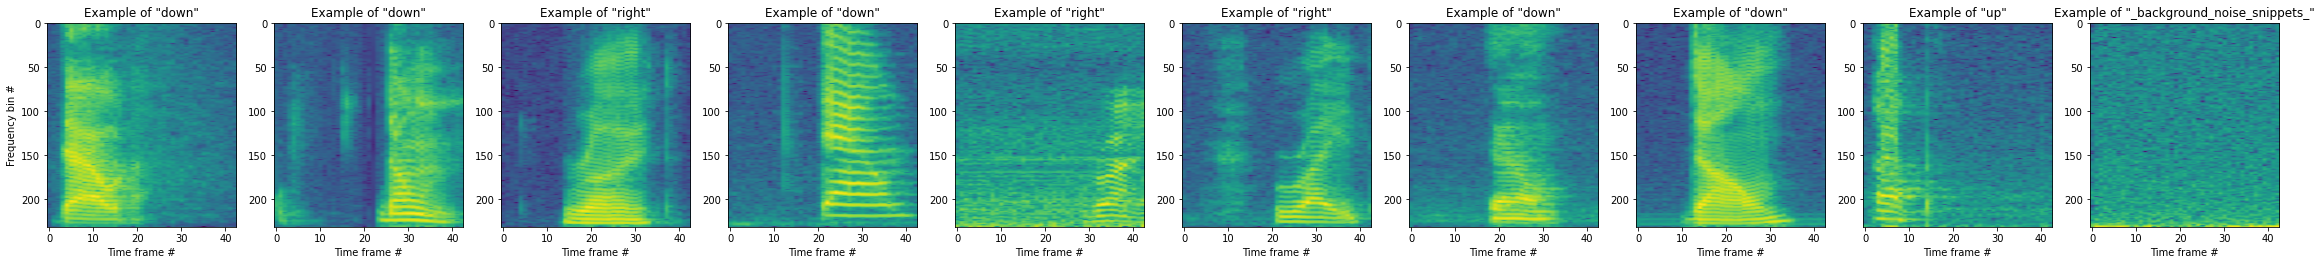

In [31]:
words = ("_background_noise_snippets_", "up", "down", "left", "right",)
input_wav_paths_and_labels = []
for i, word in enumerate(words):
  wav_paths = glob.glob(os.path.join(DATA_ROOT, word, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))
random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])
dataset = get_dataset(input_wav_paths, labels)

# Show some example spectrograms for inspection.
fig = plt.figure(figsize=(40, 100))
dataset_iter = iter(dataset)
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  spectrogram, label = next(dataset_iter)
  spectrogram = spectrogram.numpy()
  print(spectrogram.shape, label.shape)
  label = label.numpy()
  plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
  ax.set_title("Example of \"%s\"" % words[label])
  ax.set_xlabel("Time frame #")
  if i == 0:
    ax.set_ylabel("Frequency bin #")

In [32]:
# The amount of data we have is relatively small. It fits into the RAM of a 
# typical CPU or GPU. To boost training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(dataset)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

Loading dataset and converting data to numpy arrays...


In [35]:
tfjs_model_json_path = '/tmp/tfjs-sc-model/model.json'

# Load the Speech Commands model. Weights are loaded, since we won't be training
# the model from scratch. Instead, we will perform transfer learning with the
# model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of words.
# model = tf.keras.Model(inputs=orig_model.input, outputs=orig_model.layers[-2].output)
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=len(words), activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 225, 8)        136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 112, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 109, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 51, 32)         8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 25, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 22, 32)

In [ ]:
# Train the model.
model.fit(xs, ys, batch_size=256, validation_split=0.3, shuffle=True, epochs=50)

Epoch 1/50
39/39 [==============================] - 21s 544ms/step - loss: 0.6581 - acc: 0.8002 - val_loss: 0.1326 - val_acc: 0.9597
Epoch 2/50
39/39 [==============================] - 21s 537ms/step - loss: 0.2444 - acc: 0.9190 - val_loss: 0.1072 - val_acc: 0.9676
Epoch 3/50
39/39 [==============================] - 21s 538ms/step - loss: 0.1943 - acc: 0.9350 - val_loss: 0.0963 - val_acc: 0.9700
Epoch 4/50
39/39 [==============================] - 21s 536ms/step - loss: 0.1841 - acc: 0.9405 - val_loss: 0.0895 - val_acc: 0.9726
Epoch 5/50
39/39 [==============================] - 21s 535ms/step - loss: 0.1742 - acc: 0.9451 - val_loss: 0.0863 - val_acc: 0.9738
Epoch 6/50
39/39 [==============================] - 21s 533ms/step - loss: 0.1623 - acc: 0.9499 - val_loss: 0.0822 - val_acc: 0.9752
Epoch 7/50
39/39 [==============================] - 21s 544ms/step - loss: 0.1501 - acc: 0.9521 - val_loss: 0.0795 - val_acc: 0.9750
Epoch 8/50
39/39 [==============================] - 21s 544ms/step - 